In [22]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchinfo
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
import torchtext.transforms as T
from torchtext.vocab import build_vocab_from_iterator
from tqdm import tqdm
from torch.nn import functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from loadData import MovieReviews
import gensim.downloader


In [13]:
# setting hyperparameters
batch_size = 32
valid_size=0.3 # validation + testing
test_size=0.5 # tesing / (testing+validation)
learning_rate = 0.001
weight_decay = 0.0005
epoch = 10
seed = 42
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')

tokenizer = get_tokenizer("basic_english")
glove_vectors = gensim.downloader.load('glove-twitter-25')
unknown_vector = torch.randn(glove_vectors.vector_size)
max_length = 40
embed_dim = 25
label_size = 2
min_frequency = 5
unk_token = '<unk>'
bos_token = '<bos>'
eos_token = '<eos>'
pad_token= '<pad>'
unk_idx = 0
bos_idx = 1
eos_idx = 2
padding_idx = 3

print(torch.__version__)
print(device)

2.1.1+cu121
cuda


In [3]:
# data loading
df = MovieReviews()
train_data, temp_data = train_test_split(df, test_size=valid_size, random_state=seed)
val_data, test_data = train_test_split(temp_data, test_size=test_size, random_state=seed)

In [26]:
vocab = build_vocab_from_iterator(
    train_data["text"].str.split(),
    min_freq=min_frequency,
    specials=[unk_token, eos_token, bos_token, pad_token],
    #  Special symbols to add. The order of supplied tokens will be preserved.
)
vocab.set_default_index(vocab[unk_token])

In [27]:
text_transform = T.Sequential(                  # chaining multiple text transformations
    T.VocabTransform(vocab),                    # convert input batch of tokens into corresponding token ids
    T.Truncate(max_length - 2),                 # Truncate input sequence
    T.AddToken(token=bos_idx, begin=True),      # Add token to beginning or end of sequence
    T.AddToken(token=eos_idx, begin=False),
    T.ToTensor(),                               # Convert input to torch tensor
    T.PadTransform(max_length, padding_idx),    # Pad tensor to a fixed length with given padding value.
)

def collate_fn(batch: np.ndarray):
    text_placeholder, label_placeholder = [], []

    for text, label in batch:
        text = tokenizer(text)
        text = text_transform(text) # shape: [max_len, embed_dim]
        text_placeholder.append(text)
        label_placeholder.append(label)

    return torch.stack(text_placeholder), torch.Tensor(label_placeholder)

In [28]:
# DataLoader
train_iter = DataLoader(
    train_data.to_numpy(),
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
)
test_iter = DataLoader(
    test_data.to_numpy(),
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False           #　don't shuffle to check answer with original data
)
val_iter = DataLoader(
    val_data.to_numpy(),
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True
)

In [38]:
vocab_to_index = vocab.get_stoi()
vocab_size = len(vocab_to_index)
embeds = torch.randn(vocab_size, embed_dim)

for word, index in vocab_to_index.items():
    if word in glove_vectors:
        embeds[index] = torch.tensor(glove_vectors[word])

In [102]:
# model
class TextCNN(nn.Module):
    def __init__(
        self,
        embed_dim: int,
        label_size: int,
        out_chaennels: int,
        kernel_size: list[int] = [2, 3, 4],
    ):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embeds, freeze=False)
        self.convs = nn.ModuleList(
            [
                nn.Sequential(nn.Conv2d(1, out_chaennels, (kernel, embed_dim)), nn.LeakyReLU())
                for kernel in kernel_size
            ]
        )
        self.fc = nn.Linear(out_chaennels * len(kernel_size), label_size)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Batch_size, 1, Seq_len, embed_dim
        y = x.unsqueeze(1) 
        y = self.embedding(y)
        # Batch_size, filter_number, Width
        ys = [conv(y).squeeze(3) for conv in self.convs]        
        # Batch_size, filter_number
        ys = [F.max_pool1d(y, y.size(2)).squeeze(2) for y in ys] 

        y = torch.cat(ys, 1)  # Combine outputs from different kernels; 
        y = self.dropout(y) 
        y = self.fc(y)       
        return y

In [103]:
model = TextCNN(embed_dim=embed_dim, label_size=label_size, out_chaennels=32).to(device)
print(torchinfo.summary(model))

Layer (type:depth-idx)                   Param #
TextCNN                                  --
├─Embedding: 1-1                         83,050
├─ModuleList: 1-2                        --
│    └─Sequential: 2-1                   --
│    │    └─Conv2d: 3-1                  1,632
│    │    └─LeakyReLU: 3-2               --
│    └─Sequential: 2-2                   --
│    │    └─Conv2d: 3-3                  2,432
│    │    └─LeakyReLU: 3-4               --
│    └─Sequential: 2-3                   --
│    │    └─Conv2d: 3-5                  3,232
│    │    └─LeakyReLU: 3-6               --
├─Linear: 1-3                            194
├─Dropout: 1-4                           --
Total params: 90,540
Trainable params: 90,540
Non-trainable params: 0


train

In [104]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [105]:
model.train()
training_loss = []
valid_loss = []
training_accuracy = []
valid_accuracy = []

for e in range(epoch):
    correct = 0 # for train_accuracy
    for text, label in tqdm(train_iter):
        optimizer.zero_grad()
        text = text.to(device)
        label = label.to(device)
        output = model(text)
        loss = criterion(output, label.long())
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        preds = torch.argmax(output, dim=1)
        correct += (preds == label).sum().item()
        
    training_accuracy.append(correct / len(train_iter.dataset))
    training_loss.append(loss.item())
    print(f'Epoch [{e+1}/{epoch}], Training_Loss: {loss.item():.4f}')

    # Validation
    num_correct = 0 # for valid_accuracy
    model.eval()
    val_loss = 0.0
    for x, y in val_iter:
        y = y.to(device)
        preds = model(x.to(device))
        loss = criterion(preds, y.long().to(device))
        val_loss += loss.item()
        num_correct += (torch.argmax(preds, dim=1) == y).sum().item()
    
    valid_accuracy.append(num_correct / len(val_iter.dataset))
    val_loss /= len(val_iter)
    valid_loss.append(val_loss)
    print(f'Validation loss: {val_loss:.4f}')

100%|██████████| 233/233 [00:00<00:00, 235.24it/s]


Epoch [1/10], Training_Loss: 0.6416
Validation loss: 0.6665


100%|██████████| 233/233 [00:00<00:00, 296.63it/s]


Epoch [2/10], Training_Loss: 0.6216
Validation loss: 0.6139


100%|██████████| 233/233 [00:00<00:00, 254.40it/s]


Epoch [3/10], Training_Loss: 0.5549
Validation loss: 0.5643


100%|██████████| 233/233 [00:00<00:00, 269.99it/s]


Epoch [4/10], Training_Loss: 0.5088
Validation loss: 0.5404


100%|██████████| 233/233 [00:00<00:00, 233.64it/s]


Epoch [5/10], Training_Loss: 0.4552
Validation loss: 0.5202


100%|██████████| 233/233 [00:00<00:00, 274.81it/s]


Epoch [6/10], Training_Loss: 0.4261
Validation loss: 0.5256


100%|██████████| 233/233 [00:00<00:00, 289.75it/s]


Epoch [7/10], Training_Loss: 0.3386
Validation loss: 0.5222


100%|██████████| 233/233 [00:00<00:00, 255.54it/s]


Epoch [8/10], Training_Loss: 0.2922
Validation loss: 0.5389


100%|██████████| 233/233 [00:00<00:00, 279.18it/s]


Epoch [9/10], Training_Loss: 0.2924
Validation loss: 0.5544


100%|██████████| 233/233 [00:00<00:00, 267.69it/s]


Epoch [10/10], Training_Loss: 0.1545
Validation loss: 0.5897


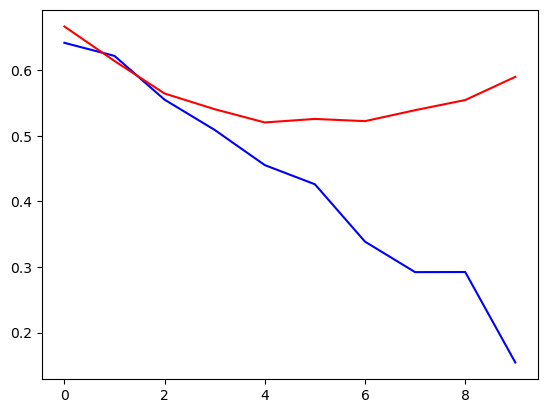

In [106]:
plt.plot(training_loss, 'b', valid_loss, 'r')

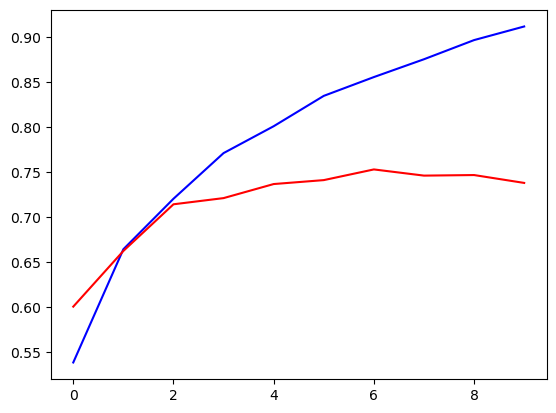

In [107]:
plt.plot(training_accuracy, 'b', valid_accuracy, 'r')

In [111]:
model.eval()
preds = []
labels = []
with torch.no_grad():
    running_hit = 0.0

    for text, label in tqdm(test_iter):
        text = text.to(device)
        label = label.to(device)

        output = model(text)
        pred = output.argmax(dim=1)
        labels.append(label)
        preds.append(pred)
    preds_cat = torch.cat(preds).to('cpu')
    labels_cat = torch.cat(labels).to('cpu')
    
    accuracy = accuracy_score(preds_cat, labels_cat)
    precision = precision_score(preds_cat, labels_cat)
    recall = recall_score(preds_cat, labels_cat)
    f1 = f1_score(preds_cat, labels_cat)
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    print(f'Test Precision: {precision * 100:.2f}%')
    print(f'Test Recall: {recall * 100:.2f}%')
    print(f'Test F1 Score: {f1 * 100:.2f}%')

100%|██████████| 50/50 [00:00<00:00, 194.02it/s]

Test Accuracy: 72.19%
Test Precision: 67.88%
Test Recall: 74.28%
Test F1 Score: 70.93%


In [109]:
# Save the model if needed
# torch.save(model.state_dict(), 'TextCNN.pth')

In [110]:
# Instantiate the model
# model = TextCNN(vocab_size, 32, label_size, padding_idx=padding_idx)

# Load the saved state dictionary
# model_path = 'TextCNN.pth'
# model_state_dict = torch.load(model_path)

# Load the state dictionary into the model
# model.load_state_dict(model_state_dict)